# Galaxy Spectra

Unlike component spectra, galaxy level spectra are by definition integrated. These spectra can only be combinations of component spectra. To see how to define emission models for galaxy level spectra see the [combined emission](../emission_models/combined_models.ipynb) docs. Here we will demonstrate the usage of a combined model to generate spectra for a galaxy. First we define that combined model.

In [1]:
import numpy as np
from unyt import Myr, kelvin, Mpc, Msun, yr

from synthesizer.emission_models import (
    AttenuatedEmission,
    BimodalPacmanEmission,
    DustEmission,
    EmissionModel,
    UnifiedAGN,
)
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody, Greybody
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, ZDist
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle import BlackHoles, Galaxy
from synthesizer.particle.stars import sample_sfhz

# Get the grids which we'll need for extraction
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)
nlr_grid = Grid("test_grid_agn-nlr", grid_dir="../../../tests/test_grid")
blr_grid = Grid("test_grid_agn-blr", grid_dir="../../../tests/test_grid")

# Get the stellar pacman model
pc_model = BimodalPacmanEmission(
    grid=grid,
    tau_v_ism=1.0,
    tau_v_birth=0.7,
    dust_curve_ism=PowerLaw(slope=-1.3),
    dust_curve_birth=PowerLaw(slope=-0.7),
    dust_emission_ism=Blackbody(temperature=100 * kelvin),
    dust_emission_birth=Blackbody(temperature=30 * kelvin),
    fesc=0.2,
    fesc_ly_alpha=0.9,
    label="stellar_total",
)


# Get the UnifiedAGN model
uni_model = UnifiedAGN(
    nlr_grid,
    blr_grid,
    covering_fraction_nlr=0.1,
    covering_fraction_blr=0.1,
    torus_emission_model=Blackbody(1000 * kelvin),
    label="agn_intrinsic",
)

# Define an emission model to attenuate the intrinsic AGN emission
att_uni_model = AttenuatedEmission(
    dust_curve=PowerLaw(slope=-1.0),
    apply_dust_to=uni_model,
    tau_v=0.7,
    emitter="blackhole",
    label="agn_attenuated",
)

gal_intrinsic = EmissionModel(
    label="total_intrinsic",
    combine=(uni_model, pc_model["intrinsic"]),
    emitter="galaxy",
)

gal_attenuated = EmissionModel(
    label="total_attenuated",
    combine=(att_uni_model, pc_model["attenuated"]),
    related_models=(gal_intrinsic,),
    emitter="galaxy",
)

# And now include the dust emission
gal_dust = DustEmission(
    dust_emission_model=Greybody(30 * kelvin, 1.2),
    dust_lum_intrinsic=gal_intrinsic,
    dust_lum_attenuated=gal_attenuated,
    emitter="galaxy",
    label="dust_emission",
)

gal_total = EmissionModel(
    label="total",
    combine=(gal_attenuated, gal_dust),
    related_models=(gal_intrinsic,),
    emitter="galaxy",
)

This emission model is going to produce a lot of spectra. In reality we probably don't want to carry around all these spectra on a galaxy or its components. Instead we can select exactly which spectra we want to save. This can either be done by setting the save flag to `False` on selected models like below.

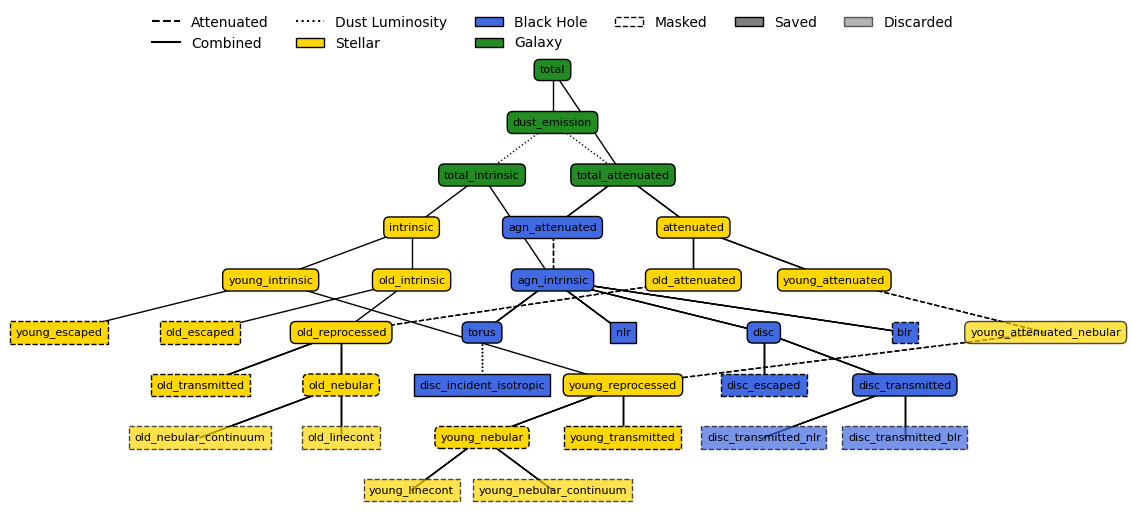

(<Figure size 1400x600 with 1 Axes>, <Axes: >)

In [2]:
# Discard some spectra
gal_total["young_linecont"].set_save(False)
gal_total["young_nebular_continuum"].set_save(False)
gal_total["old_linecont"].set_save(False)
gal_total["old_nebular_continuum"].set_save(False)
gal_total["disc_transmitted_nlr"].set_save(False)
gal_total["disc_transmitted_blr"].set_save(False)
gal_total["young_attenuated_nebular"].set_save(False)

gal_total.plot_emission_tree(figsize=(14, 6), fontsize=8)

But if we only want a handful of spectra saved this is pretty cumbersome. We can instead state exactly which spectra we want saved using the `save_spectra` method which takes an arbitrary number of emission model labels as arguments.

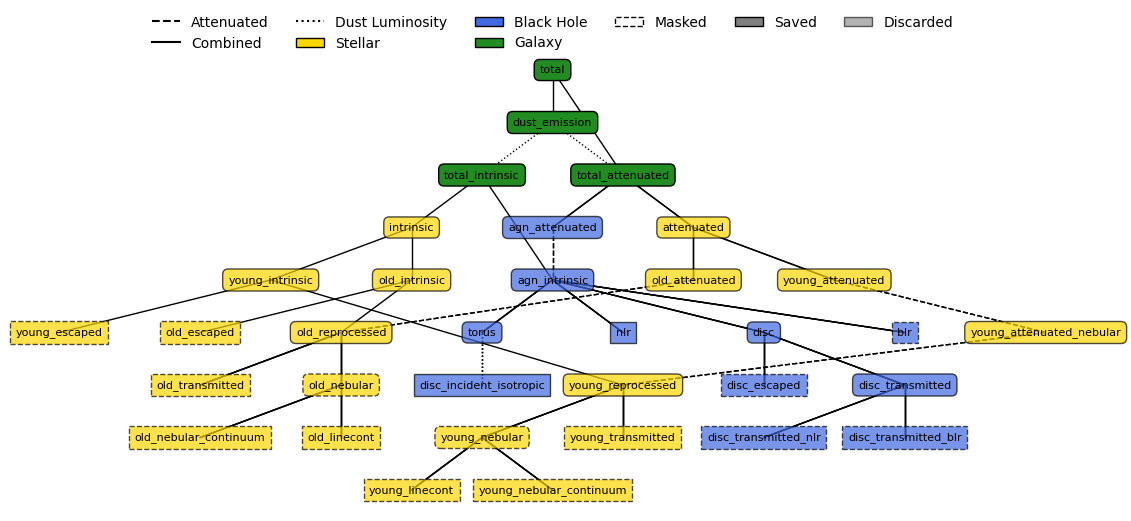

(<Figure size 1400x600 with 1 Axes>, <Axes: >)

In [3]:
gal_total.save_spectra(
    "total", "dust_emission", "total_attenuated", "total_intrinsic"
)
gal_total.plot_emission_tree(figsize=(14, 6), fontsize=8)

First lets make a galaxy containing both stars and black holes. We'll use a particle galaxy with particle ``Stars`` and ``BlackHoles``, but getting spectra is the same for both particle and parametric galaxies.

In [4]:
# Define the metallicity history
zh = ZDist.DeltaConstant(metallicity=0.01)

# Define the star formation history
sfh_p = {"max_age": 100 * Myr}
sfh = SFH.Constant(**sfh_p)

# Initialise the parametric Stars object
param_stars = ParametricStars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=zh,
    initial_mass=10**9 * Msun,
)

# Define the number of stellar particles we want
n = 10000

# Sample the parametric SFZH, producing a particle Stars object
# we will also pass some keyword arguments for some example attributes
part_stars = sample_sfhz(
    sfzh=param_stars.sfzh,
    log10ages=param_stars.log10ages,
    log10metallicities=param_stars.log10metallicities,
    nstar=n,
    current_masses=np.full(n, 10**8.7 / n) * Msun,
    redshift=1,
)

# Make fake properties
n = 4
masses = 10 ** np.random.uniform(low=7, high=9, size=n) * Msun
coordinates = np.random.normal(0, 1.5, (n, 3)) * Mpc
accretion_rates = 10 ** np.random.uniform(
    low=-2, high=1, size=n
) *  Msun / yr
metallicities = np.full(n, 0.01)

# And get the black holes object
blackholes = BlackHoles(
    masses=masses,
    coordinates=coordinates,
    accretion_rates=accretion_rates,
    metallicities=metallicities,
)

# And create the galaxy
galaxy = Galaxy(
    stars=part_stars,
    black_holes=blackholes,
    redshift=1,
)

Similarly to component spectra, to generate galaxy level spectra we call the ``get_spectra`` method on a ``Galaxy``, with the ``EmissionModel``.
There is no need to call the component methods; the ``Galaxy`` level method will handle generating the component spectra automatically. 

In [5]:
spectra = galaxy.get_spectra(gal_total)

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: overflow encountered in multiply
  out_arr = func(


Now we can plot the spectra we've generated using the ``plot_spectra`` method. Unlike the component versions of this method, we need to also flag which type of spectra we'd like to plot from the galaxy. 

We can plot only stellar spectra, only black hole spectra or the combined spectra. Below we show the combined.

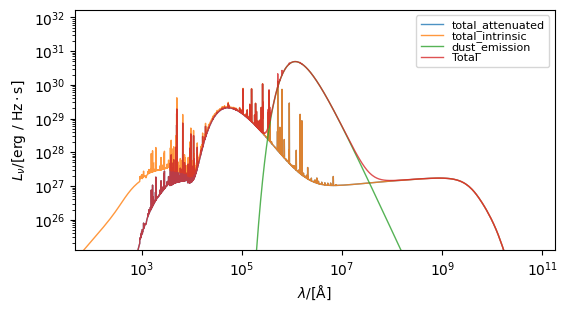

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{\\AA}]$', ylabel='$L_{\\nu}/[\\mathrm{\\rm{erg} \\ / \\ \\rm{Hz \\cdot \\rm{s}}}]$'>)

In [6]:
galaxy.plot_spectra(
    combined_spectra=True,
    stellar_spectra=False,
    black_hole_spectra=False,
    show=True,
    figsize=(6, 4),
)

## Getting observed spectra

If we want to get the observed spectra for all spectra on a galaxy we can use the ``get_observed_spectra`` method.
This uses the ``redshift`` attribute on the galaxy object by default.

In [7]:
from astropy.cosmology import Planck18 as cosmo

galaxy.get_observed_spectra(cosmo)

Which we can also plot with the ``plot_observed_spectra`` method (here only showing the combined spectra, which is the default).

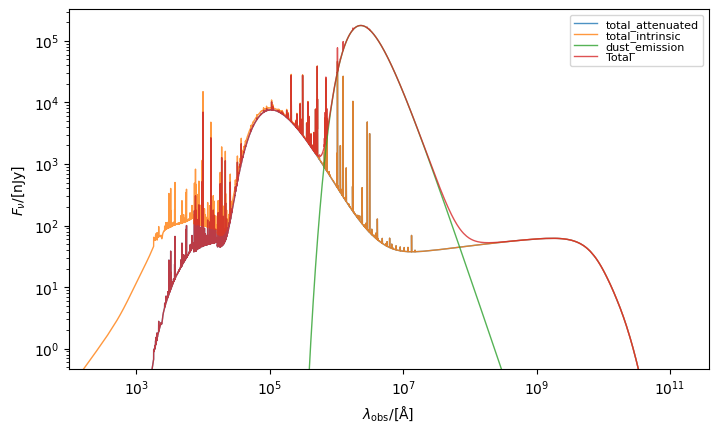

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\lambda_\\mathrm{obs}/[\\mathrm{\\AA}]$', ylabel='$F_{\\nu}/[\\mathrm{\\rm{nJy}}]$'>)

In [8]:
galaxy.plot_observed_spectra(show=True, figsize=(8, 6))

## Modifying `EmissionModel` parameters with `get_spectra`

As well as modifying a model explicitly, it's also possible to overide the properties of a model at the point `get_spectra` is called. These modifications will not be remembered by the model afterwards. As it stands, this form of modification is supported for the `dust_curve`, `tau_v`, `fesc`, `covering_fraction` and `masks`.

For more details on this see the [stars](stars.ipynb) and [blackhole](blackholes.ipynb) spectra docs where the modification is described and demonstrated in each context.